# Next Character Prediction
_Student 902011, Moleri Andrea, a.moleri@campus.unimib.it_

The task is next character prediction in a text. Starting from the provided skeleton of the code:

- properly divide the sequences into training, validation and test. Eventually use an external text for the test to assess the generalization ability
- evaluate the trained model in terms of prediction accuracy
- tune the chunk length to obtain the best performance
- modify the network architecture to obtain the best performance

In aggiunta:

Comunque vuole sia il notebook che la stampa in PDF del notebook

### Inspecting the Data

The assignment we are about to conduct is based on Dante Alighieri's "The Divine Comedy", which will serve as the dataset for the analysis in question. First, the text is downloaded from my personal GitHub repository, where it is stored in RAW format, in order to avoid compatibility problems for users who access the notebook from Google Colaboratory and do not have the required file saved locally. The text has then been preprocessed by converting all characters to lowercase to ensure uniformity and prevent discrepancies due to case sensitivity. The analysis begins with a basic examination of the text's characteristics, focusing on dimensionality and distribution. The length of the entire text is `558,240` characters. `40` unique characters are identified across the text, which include standard alphabetic characters, punctuation, and whitespace.

Next, sequences of `30` consecutive characters were extracted from the text by moving through the text with a step size of `3` characters at a time. This means that each sequence of `30` characters overlaps with the previous one by `27` characters, as only `3` new characters are included at each step. This sliding window approach allows for the extraction of subsequences that capture local patterns within the text. In total, `186,070` sequences (`558,240/3`) were generated using this method. These sequences represent sliding windows across the text, which will be useful in a short while for predictive modeling. Further observations shows that the most frequently occurring characters, notably whitespaces and common vowels such as *e*, *a*, and *i*, dominate the data distribution. This frequency distribution is visualized with a bar chart showing the `10` most frequent characters in the text corpus. After the results of this analysis, we can move on to the data preparation phase.

Text Length:
-----------------------------------
558240 characters

Text Sample:
-----------------------------------
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai,
  diro` de l'altre cose ch'i' v'ho scorte.

io non so ben ridir com'i' v'intrai,
  tant'era pien di sonno a quel punto
  che la verace via abbandonai.

ma poi ch'i' fui al pie` d'un colle giunto,
  la` dove terminava quella valle
  che m'avea di paura il cor compunto,

guardai in alto, e vidi le sue spalle
  vestite gia` de' raggi del pianeta
  che mena dritto altrui per ogne calle.

allor fu la paura un poco queta
  che nel lago del cor m'era durata
  la notte ch'i' passai con tanta pieta.

Total Unique Characters:
-----------------------------------
40

Character-to-Index 

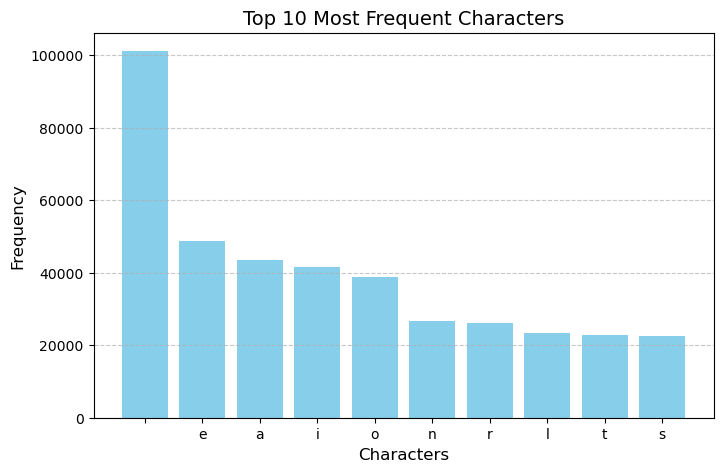

In [27]:
import numpy as np
import requests
from collections import Counter
import matplotlib.pyplot as plt

# URL of the text file containing Dante's "La Divina Commedia"
url = 'https://raw.githubusercontent.com/andreamoleri/AML-Assignments/refs/heads/main/Assignment%204/divina_commedia.txt'

# Download and preprocess the text
text = requests.get(url).text.lower()

# Display text length and a sample of the text
print(f"Text Length:\n{'-' * 35}\n{len(text)} characters")
print(f"\nText Sample:\n{'-' * 35}\n{text[30:828]}")

# Analyze unique characters in the text
chars = sorted(set(text))
print(f"Total Unique Characters:\n{'-' * 35}\n{len(chars)}")

# Create character mappings
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

print(f"\nCharacter-to-Index Mapping:\n{'-' * 35}")
for char, idx in char_indices.items():
    print(f"'{char}': {idx}")

# Define sequence parameters
maxlen, step = 30, 3

# Generate sequences and corresponding next characters
sequences = [(text[i: i + maxlen], text[i + maxlen]) for i in range(0, len(text) - maxlen, step)]
sentences, next_chars = zip(*sequences) if sequences else ([], [])

print(f"\nNumber of Sequences Generated:\n{'-' * 35}\n{len(sentences)}")

if sentences:
    print(f"\nExample of a Sentence:\n{'-' * 35}\nSentence: '{sentences[11]}'\nNext Character: '{next_chars[11]}'")

# Count character frequencies
char_counts = Counter(text)
sorted_counts = char_counts.most_common()

# Display top 10 most frequent characters
print(f"\nTop 10 Most Frequent Characters:\n{'-' * 35}")
for char, count in sorted_counts[:10]:
    print(f"{repr(char):>5}: {count} occurrences")

# Plot top 10 most frequent characters
char_labels, char_freqs = zip(*sorted_counts[:10])
plt.figure(figsize=(8, 5))
plt.bar(char_labels, char_freqs, color='skyblue')
plt.title('Top 10 Most Frequent Characters', fontsize=14)
plt.xlabel('Characters', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preparing the Data

The preprocessing stage involves preparing sequences from the text data for training, validation, and testing purposes. This phase builds on the previous data inspection results and ensures the sequences are appropriately structured for machine learning models. The initial steps map each unique character into integer indices. As previously discussed, the data is tokenized into sequences of `30` characters, with a step of `3` between each sequence. This choice tries to balance sequence length for context learning while preventing highly overlapping sequences that could lead to redundancies. The text sequences (`sentences`) and their corresponding target characters (`next_chars`) are one-hot encoded into arrays `x` and `y`. Here, each character is transformed into a binary vector representation across `40` unique characters, with `40` being the total number of unique characters identified during the data inspection phase. After encoding, the sequences are split into training, validation, and test subsets. The proportions are set as follows:

- `80%` **for Training**: used to train the machine learning model. As a consequence, the training set is made up of `148,856` sequences with shapes `(30, 40)`
- `10%` **for Validation**: used to tune model hyperparameters and prevent overfitting during training. As a consequence, the validation set is made up of `18,607` sequences with shapes `(30, 40)`
- `10%` **for Testing**: reserved to assess how well the trained model generalizes on unseen data. As a consequence, the test set is made up of `18,607` sequences with shapes `(30, 40)`

In [28]:
# Define the maximum sequence length to be used for training
maxlen = 30

# Obtain the unique characters in the text and sort them to ensure consistent encoding
chars = sorted(set(text))
# Map each unique character to a unique integer index.
char_indices = {char: i for i, char in enumerate(chars)}
# Map each integer index back to its corresponding character.
indices_char = {i: char for char, i in char_indices.items()}
# Display the total number of unique characters.
print(f"Total characters: {len(chars)}")

# Initialize lists to store input sequences and their corresponding target characters
sentences = []
next_chars = []

# Generate sequences of length `maxlen` with their respective next characters as targets
# Loop with a step of 3 to avoid overly similar sequences
for i in range(0, len(text) - maxlen, 3):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])

# Display the total number of sequences generated for training
print(f"Number of sequences generated: {len(sentences)}")

# Initialize the input (x) and output (y) arrays for training with boolean values
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

# One-hot encode the sequences and their respective next characters
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1  # One-hot encode the input sequence characters
    y[i, char_indices[next_chars[i]]] = 1  # One-hot encode the target characters

# Display the shapes of the input and output arrays to verify their structure
print('\nInput (x) and Output (y) shapes:')
print(x.shape)
print(y.shape)

# Define the proportions of data to be used for training, validation, and testing splits
train_split = 0.8
val_split = 0.1

# Calculate the sizes of the training and validation sets based on the total number of sequences
train_size = int(len(sentences) * train_split)
val_size = int(len(sentences) * val_split)

# Split the data into training, validation, and test sets
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]
x_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

# Display the size of each data split to ensure proper partitioning
print('\nData split:')
print(f'Training set: {x_train.shape}, {y_train.shape}')
print(f'Validation set: {x_val.shape}, {y_val.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')

Total characters: 40
Number of sequences generated: 186070

Input (x) and Output (y) shapes:
(186070, 30, 40)
(186070, 40)

Data split:
Training set: (148856, 30, 40), (148856, 40)
Validation set: (18607, 30, 40), (18607, 40)
Test set: (18607, 30, 40), (18607, 40)


## Building the Networks

Let's now move on to the third code cell of this notebook, in which three distinct neural network architectures are built. Each of networks at hand has been designed with progressively greater complexity, in order to enable a structured comparison of their performance. Hypotheses will also be drawn regarding the presumed effectiveness and characteristics of the three networks, based mainly on theoretical notions acquired during the course and the laboratories. To have a confirmation regarding what has been hypothesized, it will be necessary to wait for the next code cell, in which the actual training of the proposed networks will take place, and therefore it will be possible to confirm, -or deny-, them. 

For completenessâ€™s sake, before analyzing the three long short-term networks that have been built, we report an excellent definition of LSTMs taken directly from the [MathWorks website](https://www.mathworks.com/discovery/lstm.html#:~:text=A%20long%20short%2Dterm%20memory,between%20time%20steps%20of%20data.): _"a long short-term memory (LSTM) network is a type of recurrent neural network (RNN). LSTMs are predominantly used to learn, process, and classify sequential data because they can learn long-term dependencies between time steps of data. In other words, LSTM networks are a specialized form of the RNN architecture inputs. They contain a hidden state and loops, which allow the network to store past information in the hidden state and operate on sequences network learns weights for both the inputs and the hidden state. When implemented, the output is based on the current input, as well as the hidden state, which is based on previous inputs"_. 

---

### Network 1: Simple Baseline Model
The first network is designed as a baseline model, featuring a single LSTM layer and a dense output layer. Its architecture is intentionally minimalistic, focusing on capturing only the most basic patterns in the data. The input layer processes sequences of length `30`, in which each of the `40` unique characters that compose the corpus is one-hot encoded. This is followed by a single LSTM layer containing `64` units. Finally, a dense output layer with a softmax activation maps the outputs of the LSTM to a probability distribution over the `40` possible characters. This network is expected to achieve a good level of predictive accuracy by leveraging the sequential dependencies in the text. However, due to its limited complexity, it is likely to struggle when compared to the other two models.

### Network 2: Intermediate Model
The second network introduces additional complexity. The architecture retains the same input configuration as Network 1 but incorporates one LSTM layer with `128` units. The doubling of units in the LSTM layer allows the network to better capture characters relationships. The dense output layer, again with a softmax activation, ensures that compatibility with the required probability distribution over the output characters is met. To combat overfitting, dropout layers are added, with a dropout rate of `0.2`. This model is expected to outperform the baseline network in capturing more complex sequential patterns due to its increased depth. However, the expanded parameter count introduces a higher risk of slight overfitting, particularly if the training data lacks diversity or is insufficient in size. Since the training data is exclusively based on Dante's "La Divina Commedia", and not on a broader range of corpora, it is realistic to think that these doubts could materialize. To recap, higher accuracy in testing is to be expected, at the expense of some slight overfitting.

### Network 3: Advanced Model
The third network represents the most advanced design of the three. As with the previous networks, the input layer handles sequences of length `30` with one-hot encoding of the `40` unique characters. The model then employs two stacked LSTM layers, the first one containing `256` units, and the second one containing `128` units, in order to capture dependencies more effectively. Once again, to combat overfitting, dropout layers are added. The dense output layer maintains the consistency of the output representation. This model is hypothesized to achieve superior test accuracy compared to the earlier designs, because of its advanced capacity to learn more complex patterns. Nevertheless, the increased complexity also may heighten its susceptibility to overfitting. To recap, once again higher accuracy on the test set is expected, along with a slight overfitting.

---

To draw conclusions, Network 2 is expected to surpass Network 1 in terms of test accuracy. This improvement is attributed to Network 2's greater capacity for modeling complex temporal dependencies, which are critical for the task at hand. Furthermore, Network 3 is projected to outperform Network 2 in test accuracy. This advantage is expected due to its additional layers and the inclusion of regularization mechanisms, which collectively enhance its ability to generalize effectively to unseen data. However, Network 2 and 3 may also exhibit signs of overfitting, a potential consequence of its larger parameter count and deeper architecture. Should this occur, it would highlight the trade-offs between model capacity and regularization, particularly in the context of character-level language modeling. As a reference note, more complex and better models could have been built to solve the assignment. However, given the limitations of computational resources of the machine on which this assignment was written, and of training time, it was decided to accept as a compromise these architectures that, although relatively simple, still allow us to draw interesting conclusions on the problem at hand.

In [29]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

# ================================
# Network 1: Simple Baseline Model
# ================================

print("Building Model 1:")

# Define the chunk length for the first model
chunk_length_1 = 30  

# Prepare the training, validation, and test datasets for Model 1
x_train_1 = x_train[:, :chunk_length_1, :]  
x_val_1 = x_val[:, :chunk_length_1, :]
x_test_1 = x_test[:, :chunk_length_1, :]

# Initialize a Sequential model
model_1 = Sequential()

# Add an LSTM layer with 64 units
model_1.add(LSTM(64, input_shape=(chunk_length_1, len(chars))))  

# Add a Dense layer with a softmax activation function for classification
model_1.add(Dense(len(chars), activation='softmax')) 

# Compile the model using the RMSprop optimizer with a learning rate of 0.01
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display the summary of Model 1
model_1.summary()

# =============================
# Network 2: Intermediate Model
# =============================

print("Building Model 2:")

# Define the chunk length for the second model
chunk_length_2 = 35  

# Prepare the training, validation, and test datasets for Model 2
x_train_2 = x_train[:, :chunk_length_2, :]  
x_val_2 = x_val[:, :chunk_length_2, :]
x_test_2 = x_test[:, :chunk_length_2, :]

# Initialize a Sequential model
model_2 = Sequential()

# Add an LSTM layer with 128 units
model_2.add(LSTM(128, input_shape=(chunk_length_2, len(chars)))) 

# Add a Dropout layer with a dropout rate of 0.2 to prevent overfitting
model_2.add(Dropout(0.2))

# Add a Dense layer with a softmax activation function for classification
model_2.add(Dense(len(chars), activation='softmax')) 

# Compile the model using the RMSprop optimizer with a learning rate of 0.01
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display the summary of Model 2
model_2.summary()

# =========================
# Network 3: Advanced Model
# =========================

print("\nBuilding Model 3:")

# Define the chunk length for the third model
chunk_length_3 = 40 

# Prepare the training, validation, and test datasets for Model 3
x_train_3 = x_train[:, :chunk_length_3, :]  
x_val_3 = x_val[:, :chunk_length_3, :]
x_test_3 = x_test[:, :chunk_length_3, :]

# Initialize a Sequential model
model_3 = Sequential()

# Add the first LSTM layer with 256 units and set return_sequences=True for the subsequent LSTM layer
model_3.add(LSTM(256, input_shape=(chunk_length_3, len(chars)), return_sequences=True)) 

# Add a Dropout layer with a dropout rate of 0.2 to prevent overfitting
model_3.add(Dropout(0.2)) 

# Add the second LSTM layer with 128 units
model_3.add(LSTM(128))

# Add a Dense layer with a softmax activation function for classification
model_3.add(Dense(len(chars), activation='softmax')) 

# Compile the model using the RMSprop optimizer with a learning rate of 0.01
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01) 

# Compile the model
model_3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display the summary of Model 3
model_3.summary()

Building Model 1...
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                26880     
                                                                 
 dense_22 (Dense)            (None, 40)                2600      
                                                                 
Total params: 29480 (115.16 KB)
Trainable params: 29480 (115.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Building Model 2...
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 128)               86528     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                  

Evaluating Model 1...
Training Model 1...
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.7381 - accuracy: 0.2242
******* Epoch: 1 ********
***** Starting sentence *****
nde perugia sente freddo e cal
*****************************
***** Generated text *****
nde perugia sente freddo e cal che si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si

73/73 [==============================] - 77s 1s/step - loss: 2.7381 - accuracy: 0.2242 - val_loss: 2.3114 - val_accuracy: 0.3186
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.2076 - accuracy: 0.3222
******* Epoch: 2 ********
***** Starting sentence *****
se,
  col

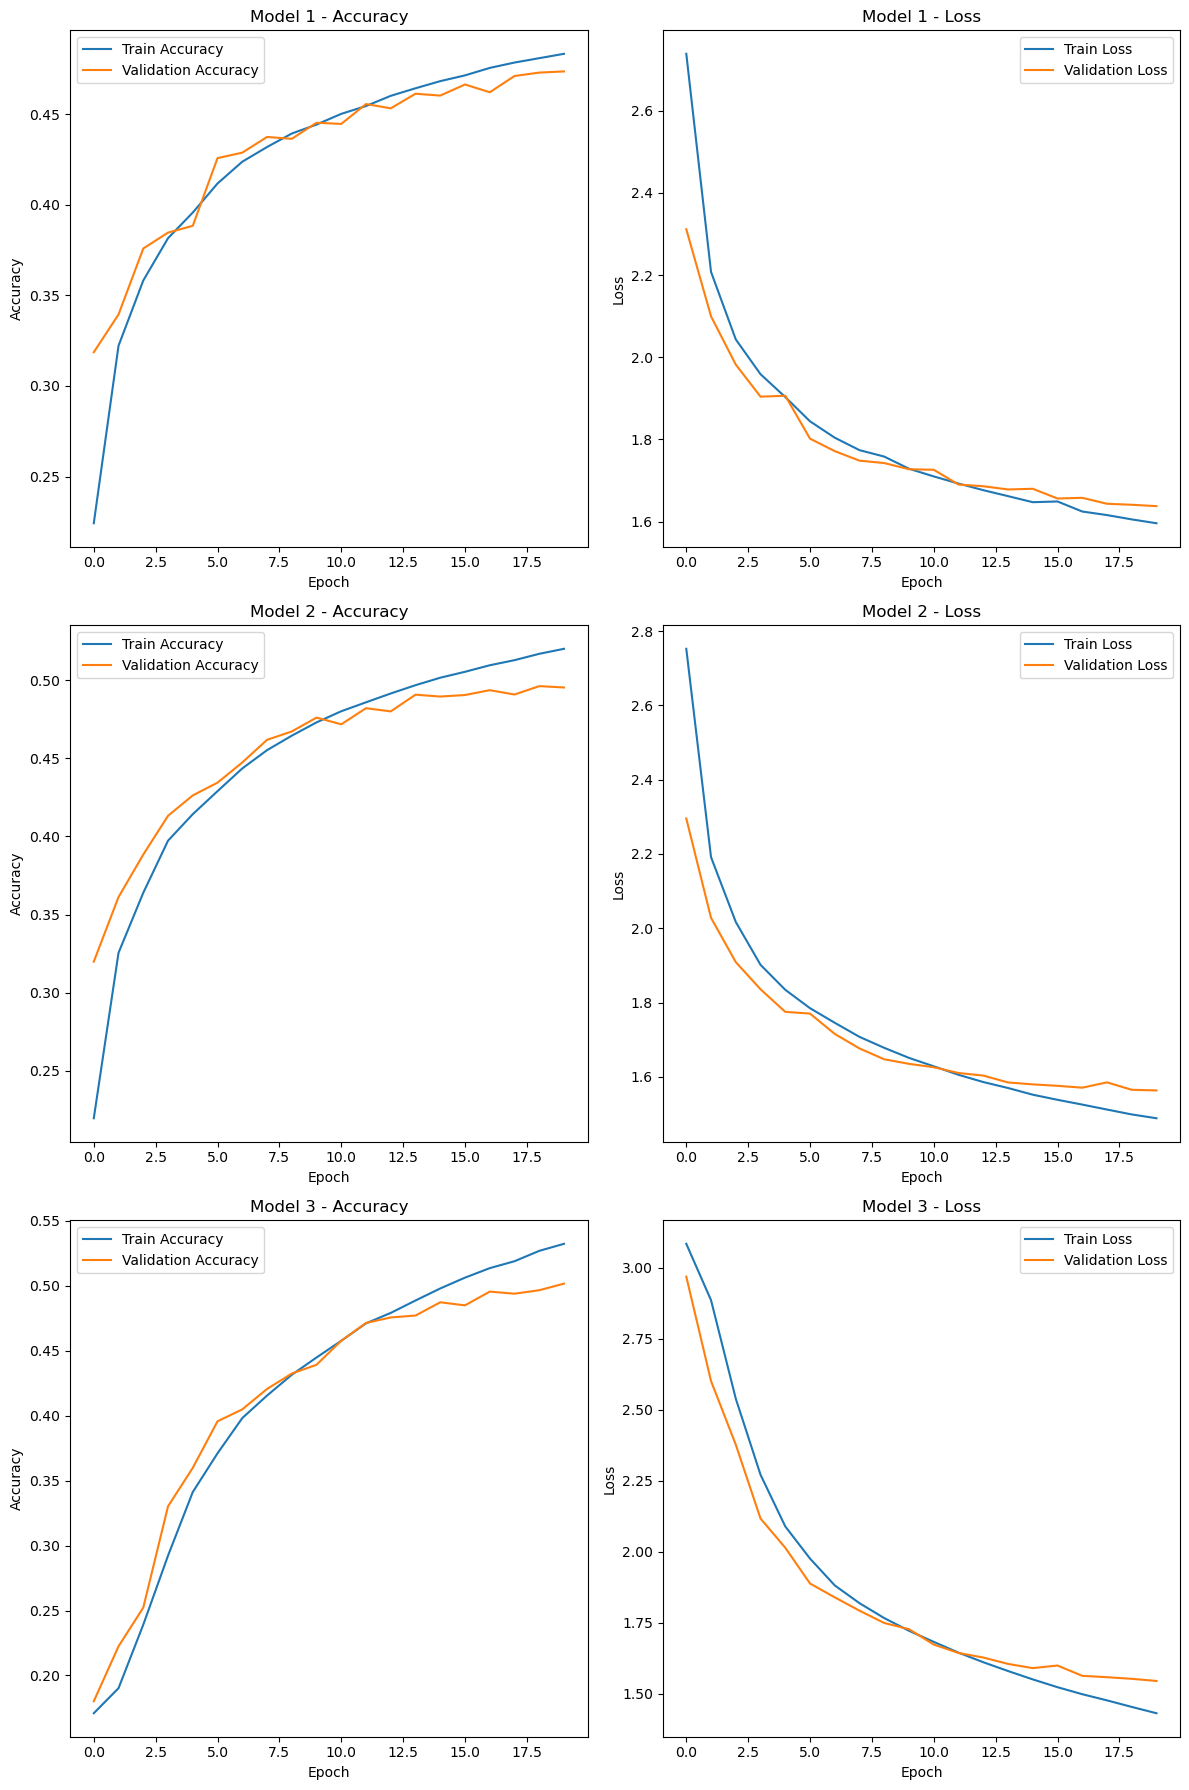


Test Results:

Model 1 - Test Loss: 1.6464, Test Accuracy: 0.4751
Model 2 - Test Loss: 1.5629, Test Accuracy: 0.5021
Model 3 - Test Loss: 1.5242, Test Accuracy: 0.5097


In [30]:
import random
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback

def testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _):
    """
    Generate and print a text sample from the model after a training epoch.

    Parameters:
        model: Trained model used for prediction.
        text (str): Input text data used for training.
        char_indices (dict): Mapping from characters to their indices.
        indices_char (dict): Mapping from indices to their respective characters.
        maxlen (int): Length of each input sequence.
        epoch (int): The current epoch number.
        _: Placeholder for unused additional arguments.

    Returns:
        None
    """
    print()
    print(f"******* Epoch: {epoch+1} ********")
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

    print("***** Starting sentence *****")
    print(sentence)
    print("*****************************")

    for _ in range(400): 
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char
        generated += next_char

    print("***** Generated text *****")
    print(generated)
    print()

def prepare_data_for_chunk_length(text, chars, char_indices, maxlen, step=3):
    """
    Prepares input-output pairs for training based on a sliding window over the text.

    Parameters:
        text (str): Input text data.
        chars (list): Unique characters in the text.
        char_indices (dict): Mapping from characters to their indices.
        maxlen (int): Length of each input sequence.
        step (int): Step size for the sliding window (default: 3).

    Returns:
        tuple: A tuple (x, y) where x is the input data and y is the target data.
    """
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
    y = np.zeros((len(sentences), len(chars)), dtype=bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

def train_and_store_history(model, x, y, text, char_indices, indices_char, maxlen, batch_size, epochs, model_name):
    """
    Train a model and store its training history. Evaluate performance on a test set.

    Parameters:
        model: The neural network model to train.
        x (ndarray): Input training data.
        y (ndarray): Target training data.
        text (str): Input text data used for sampling during training.
        char_indices (dict): Mapping from characters to their indices.
        indices_char (dict): Mapping from indices to their respective characters.
        maxlen (int): Length of each input sequence.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        model_name (str): Name of the model (used for reporting).

    Returns:
        tuple: A tuple (history, test_loss, test_accuracy).
    """
    split_train = int(len(x) * 0.8)
    split_val = int(len(x) * 0.9)
    x_train, y_train = x[:split_train], y[:split_train]
    x_val, y_val = x[split_train:split_val], y[split_train:split_val]
    x_test, y_test = x[split_val:], y[split_val:]

    print(f"Training {model_name}...")
    print_callback = LambdaCallback(on_epoch_end=lambda epoch, _: testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _))

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[print_callback],
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return history, test_loss, test_accuracy

def plot_all_histories(histories, model_names):
    """
    Plot training and validation accuracy and loss for multiple models.

    Parameters:
        histories (list): List of training histories for each model.
        model_names (list): List of names corresponding to the models.

    Returns:
        None
    """
    plt.figure(figsize=(12, 18))
    for i, (history, name) in enumerate(zip(histories, model_names)):
        plt.subplot(len(histories), 2, 2 * i + 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{name} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(len(histories), 2, 2 * i + 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Set the batch size and number of epochs for model training
batch_size = 2048
epochs = 20

# Initialize lists to store training histories, model names, and results
histories = []
model_names = []
results = []

# Prepare data for the first model using a chunk length of 30
x_1, y_1 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=30)
print("Evaluating Model 1...")
# Train Model 1 and store the history, test loss, and test accuracy
history_1, test_loss_1, test_accuracy_1 = train_and_store_history(model_1, x_1, y_1, text, char_indices, indices_char, 30, batch_size, epochs, "Model 1")
# Append the results for Model 1
histories.append(history_1)
model_names.append("Model 1")
results.append(("Model 1", test_loss_1, test_accuracy_1))

# Prepare data for the second model using a chunk length of 35
x_2, y_2 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=35)
print("\nEvaluating Model 2...")
# Train Model 2 and store the history, test loss, and test accuracy
history_2, test_loss_2, test_accuracy_2 = train_and_store_history(model_2, x_2, y_2, text, char_indices, indices_char, 35, batch_size, epochs, "Model 2")
# Append the results for Model 2
histories.append(history_2)
model_names.append("Model 2")
results.append(("Model 2", test_loss_2, test_accuracy_2))

# Prepare data for the third model using a chunk length of 40
x_3, y_3 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=40)
print("\nEvaluating Model 3...")
# Train Model 3 and store the history, test loss, and test accuracy
history_3, test_loss_3, test_accuracy_3 = train_and_store_history(model_3, x_3, y_3, text, char_indices, indices_char, 40, batch_size, epochs, "Model 3")
# Append the results for Model 3
histories.append(history_3)
model_names.append("Model 3")
results.append(("Model 3", test_loss_3, test_accuracy_3))

# Plot the training histories of all models
plot_all_histories(histories, model_names)

# Print the test results
print("\nTest Results:\n")
# Sort the results based on test accuracy (ascending order)
results.sort(key=lambda x: x[2], reverse=False)
# Display the test results for each model
for model_name, test_loss, test_accuracy in results:
    print(f"{model_name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")